# Lab 1: Subset Selection Methods

## Best Subset Selection

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [138]:
import statsmodels.api as sm

#read the data and drop null values
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0, na_values='NA').dropna()
hitters = pd.get_dummies(hitters, drop_first=True)

X = hitters[hitters.columns.drop('Salary')]
y = hitters['Salary']

#if using statsmodels.api.OLS need to add a constant so an intercept is calculated each time
#can also use statsmodels.formula.api.ols but it's about 3x slower
X = sm.add_constant(X)

In [140]:
import itertools
import statsmodels.formula.api as smf
import statsmodels.api as sm
import time

#if using statsmodels.api.OLS need to add a constant so intercept is calculated
#also statsmodels.api.OLS is 3-4 times faster than statsmodels.formula.api.ols
X = sm.add_constant(X)

#best subset selection - takes about 10 minutes
bss_models = {}

TIC = time.time()

for i in range(1, len(X.columns)):
    tic = time.time()
    #this counter will count the number of models that are fitted
    ctr = 0
    #reset the minimum rss each iteration
    min_rss = 1e100
    #loop through combinations of variables ('const' stays in every model - intercept)
    for combo in itertools.combinations(X.columns.drop('const'), i):
        #fit the model with the constant and combo of variables
        lr = sm.OLS(y, X[['const'] + list(combo)]).fit()
        #calculate the RSS
        calc_rss = ((lr.predict() - y) ** 2).sum()
        #check if the calculated RSS is less than previous minimum
        if calc_rss < min_rss:
            min_rss = calc_rss
            min_model = lr
        ctr += 1
    #at the end of the loop, add the best model to the dictionary along with its RSS
    bss_models[i] = [min_model, min_rss]
    toc = time.time()
    print('Processed {} models on {} predictors in {} seconds' \
          .format(ctr, i, toc-tic))
    
TOC = time.time()
print('\nTotal elapsed time: {} seconds'.format(TOC-TIC))

Processed 19 models on 1 predictors in 0.02000117301940918 seconds
Processed 171 models on 2 predictors in 0.16600942611694336 seconds
Processed 969 models on 3 predictors in 0.957054853439331 seconds
Processed 3876 models on 4 predictors in 3.8792216777801514 seconds
Processed 11628 models on 5 predictors in 11.791674375534058 seconds
Processed 27132 models on 6 predictors in 27.955599069595337 seconds
Processed 50388 models on 7 predictors in 52.80101990699768 seconds
Processed 75582 models on 8 predictors in 80.62761187553406 seconds
Processed 92378 models on 9 predictors in 100.30473685264587 seconds
Processed 92378 models on 10 predictors in 102.1488425731659 seconds
Processed 75582 models on 11 predictors in 84.79585003852844 seconds
Processed 50388 models on 12 predictors in 57.52729034423828 seconds
Processed 27132 models on 13 predictors in 31.444798469543457 seconds
Processed 11628 models on 14 predictors in 13.683782577514648 seconds
Processed 3876 models on 15 predictors in

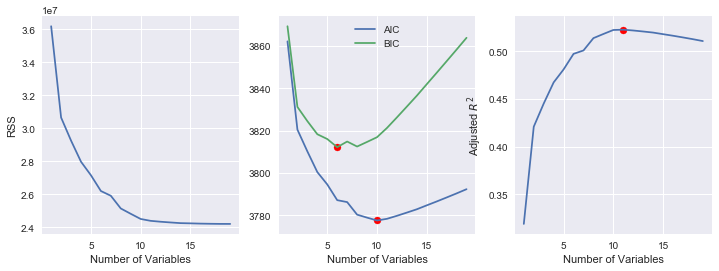

In [193]:
indices = sorted(list(bss_models.keys()))

aic = np.array([])
bic = np.array([])
adj_r2 = np.array([])
rss = np.array([])


for i in range(1, len(bss_models)+1):
    aic = np.append(aic, bss_models[i][0].aic)
    bic = np.append(bic, bss_models[i][0].bic)
    adj_r2 = np.append(adj_r2, bss_models[i][0].rsquared_adj)
    rss = np.append(rss, bss_models[i][1])
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(indices, rss)
ax1.set(xlabel='Number of Variables', ylabel='RSS')

ax2.plot(indices, aic)
ax2.plot(indices, bic)
ax2.legend(['AIC', 'BIC'], loc=9)
ax2.scatter(aic.argmin()+1, aic[aic.argmin()], c='r')
ax2.scatter(bic.argmin()+1, bic[bic.argmin()], c='r')
ax2.set(xlabel='Number of Variables')

ax3.plot(indices, adj_r2)
ax3.scatter(adj_r2.argmax()+1, adj_r2[adj_r2.argmax()], c='r')
ax3.set(xlabel='Number of Variables', ylabel=r'Adjusted $R^2$');

## Forward and Backward Stepwise Selection

In [202]:
#forward selection

unused_vars = X.columns.drop('const')
model_vars = []
fs_models = {}

for i in range(len(unused_vars)):
    min_rss = 1e100
    for v in unused_vars:
        lr = sm.OLS(y, X[['const'] + list(model_vars) + [v]]).fit()
        calc_rss = ((lr.predict() - y) ** 2).sum()
        if calc_rss < min_rss:
            min_rss = calc_rss
            min_model = lr
            min_var = v
    model_vars.append(min_var)
    unused_vars = unused_vars.drop(min_var)
    fs_models[i+1] = [min_model, min_rss]

In [203]:
#backward selection
model_vars = X.columns.drop('const')
omitted_vars = []
bs_models = {}

for i in range(len(model_vars), 0, -1):
    lr = sm.OLS(y, X[['const'] + list(model_vars)]).fit()
    calc_rss = ((lr.predict() - y) ** 2).sum()
    bs_models[i] = [lr, calc_rss]
    min_rss = 1e100
    if len(model_vars) > 1:
        for v in model_vars:
            lr = sm.OLS(y, X[['const'] + list(model_vars.drop(v))]).fit()
            calc_rss = ((lr.predict() - y) ** 2).sum()
            if calc_rss < min_rss:
                min_rss = calc_rss
                min_var = v
        model_vars = model_vars.drop(v)

In [210]:
ind = 7

print('{} Variable(s)\n-------------'.format(ind))
print('Best subset selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(bss_models[ind][0].params.index.drop('const')), 
              bss_models[ind][1]))
print('Forward selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(fs_models[ind][0].params.index.drop('const')), fs_models[ind][1]))
print('Backward selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(bs_models[ind][0].params.index.drop('const')), bs_models[ind][1]))

7 Variable(s)
-------------
Best subset selection
	Variables: ['Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W']
	RSS: 25906547.500623748

Forward selection
	Variables: ['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']
	RSS: 25954217.081713855

Backward selection
	Variables: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years']
	RSS: 31536216.579032496



## Choosing Among Models Using the Validation Set Approach and Cross-Validation